In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Tuesday-WorkingHours.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Monday-WorkingHours.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Wednesday-workingHours.pcap_ISCX.csv


In [31]:
#imports 
import os, sys, glob, gc, time, json, joblib, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

In [32]:
INPUT_DIR = '/kaggle/input/network-intrusion-dataset'
OUTPUT_DIR = '/kaggle/working/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

all_csvs = glob.glob(os.path.join(INPUT_DIR, '**', '*.csv'), recursive=True)
print(f"Found {len(all_csvs)} CSV files:")

for f in sorted(all_csvs):
    size_mb = os.path.getsize(f) / 1e6
    print(f"  {os.path.basename(f):<50} {size_mb:6.1f} MB")

Found 8 CSV files:
  Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv     77.1 MB
  Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv   76.9 MB
  Friday-WorkingHours-Morning.pcap_ISCX.csv            58.3 MB
  Monday-WorkingHours.pcap_ISCX.csv                   176.9 MB
  Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv   83.1 MB
  Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv   52.0 MB
  Tuesday-WorkingHours.pcap_ISCX.csv                  135.1 MB
  Wednesday-workingHours.pcap_ISCX.csv                225.2 MB


In [33]:
print("  DATASET OVERVIEW")
print(f"  df.shape  -> {df.shape}")
print(f"  df.size   -> {df.size:,}  (rows × columns)")
print(f"  RAM usage -> {df.memory_usage(deep=True).sum()/1e6:.1f} MB")
print(f"\nAll {df.shape[1]} columns:")
for i, c in enumerate(df.columns):
    print(f"  [{i:3d}] {c}")

  DATASET OVERVIEW
  df.shape  -> (1911555, 79)
  df.size   -> 151,012,845  (rows × columns)
  RAM usage -> 611.7 MB

All 79 columns:
  [  0] Destination Port
  [  1] Flow Duration
  [  2] Total Fwd Packets
  [  3] Total Backward Packets
  [  4] Total Length of Fwd Packets
  [  5] Total Length of Bwd Packets
  [  6] Fwd Packet Length Max
  [  7] Fwd Packet Length Min
  [  8] Fwd Packet Length Mean
  [  9] Fwd Packet Length Std
  [ 10] Bwd Packet Length Max
  [ 11] Bwd Packet Length Min
  [ 12] Bwd Packet Length Mean
  [ 13] Bwd Packet Length Std
  [ 14] Flow Bytes/s
  [ 15] Flow Packets/s
  [ 16] Flow IAT Mean
  [ 17] Flow IAT Std
  [ 18] Flow IAT Max
  [ 19] Flow IAT Min
  [ 20] Fwd IAT Total
  [ 21] Fwd IAT Mean
  [ 22] Fwd IAT Std
  [ 23] Fwd IAT Max
  [ 24] Fwd IAT Min
  [ 25] Bwd IAT Total
  [ 26] Bwd IAT Mean
  [ 27] Bwd IAT Std
  [ 28] Bwd IAT Max
  [ 29] Bwd IAT Min
  [ 30] Fwd PSH Flags
  [ 31] Bwd PSH Flags
  [ 32] Fwd URG Flags
  [ 33] Bwd URG Flags
  [ 34] Fwd Header Length

In [7]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,...,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.687500,3.0,0.0,3,3,3,3.0,0.0,3,3,...,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.623047,109.0,0.0,109,109,0,0.0,0.0,0,0,...,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.539062,52.0,0.0,52,52,0,0.0,0.0,0,0,...,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.531250,34.0,0.0,34,34,0,0.0,0.0,0,0,...,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.687500,3.0,0.0,3,3,3,3.0,0.0,3,3,...,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [6]:
# combining csvs and memory handling
def reduce_mem_usage(df):
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = df[col].astype(np.float32)
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = df[col].astype(np.int32)
    return df

df_list = []
MAX_ROWS = 2_000_000  

for path in sorted(all_csvs):
    try:
        tmp = pd.read_csv(path, low_memory=False)
        tmp.columns = tmp.columns.str.strip()         
        tmp = reduce_mem_usage(tmp)
        df_list.append(tmp)
        print(f"Loaded {os.path.basename(path):<50} → {len(tmp):,} rows")
        
        if sum(len(d) for d in df_list) >= MAX_ROWS:
            print("Reached row limit stopping early")
            break
    except Exception as e:
        print(f"Skipped {os.path.basename(path)} → {e}")

df = pd.concat(df_list, ignore_index=True)
del df_list
gc.collect()

print(f"\nfinal shape: {df.shape} | memory: {df.memory_usage(deep=True).sum()/1e6:.1f} MB")

Loaded Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv   → 225,745 rows
Loaded Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv → 286,467 rows
Loaded Friday-WorkingHours-Morning.pcap_ISCX.csv          → 191,033 rows
Loaded Monday-WorkingHours.pcap_ISCX.csv                  → 529,918 rows
Loaded Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv → 288,602 rows
Loaded Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv → 170,366 rows
Loaded Tuesday-WorkingHours.pcap_ISCX.csv                 → 445,909 rows
Reached row limit – stopping early

final shape: (2138040, 79) | memory: 784.9 MB


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2138040 entries, 0 to 2138039
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int32  
 1   Flow Duration                int32  
 2   Total Fwd Packets            int32  
 3   Total Backward Packets       int32  
 4   Total Length of Fwd Packets  int32  
 5   Total Length of Bwd Packets  int32  
 6   Fwd Packet Length Max        int32  
 7   Fwd Packet Length Min        int32  
 8   Fwd Packet Length Mean       float32
 9   Fwd Packet Length Std        float32
 10  Bwd Packet Length Max        int32  
 11  Bwd Packet Length Min        int32  
 12  Bwd Packet Length Mean       float32
 13  Bwd Packet Length Std        float32
 14  Flow Bytes/s                 float32
 15  Flow Packets/s               float32
 16  Flow IAT Mean                float32
 17  Flow IAT Std                 float32
 18  Flow IAT Max                 int32  
 19  

In [10]:
df.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,...,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.137690e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,...,2.138040e+06,2.138040e+06,2.138040e+06,2138040.0,2138040.0,2138040.0,2138040.0,2138040.0,2138040.0,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2.138040e+06,2138040.0,2.138040e+06,2.138040e+06,2.138040e+06
mean,8.844073e+03,1.050381e+07,9.297949e+00,1.045199e+01,5.474263e+02,1.589250e+04,1.991782e+02,1.990966e+01,5.743940e+01,6.437890e+01,6.146718e+02,4.338770e+01,2.262506e+02,2.305764e+02,inf,inf,9.082484e+05,1.647596e+06,4.740383e+06,1.429144e+05,1.018627e+07,1.813472e+06,1.404105e+06,4.586319e+06,1.019014e+06,...,5.743940e+01,2.262506e+02,-1.039270e+04,0.0,0.0,0.0,0.0,0.0,0.0,9.297949e+00,5.474124e+02,1.045199e+01,1.589255e+04,7.537434e+03,2.155572e+03,5.190433e+00,-3.638637e+03,7.808680e+04,3.903648e+04,1.500872e+05,5.672251e+04,3846537.5,5.133920e+05,4.216274e+06,3.444533e+06
std,1.897418e+04,2.884471e+07,7.504731e+02,1.001623e+03,1.095083e+04,2.270143e+06,7.500736e+02,6.300486e+01,1.929771e+02,2.915674e+02,1.591809e+03,7.003286e+01,5.036499e+02,7.122104e+02,NaN,NaN,3.974032e+06,5.897681e+06,1.529297e+07,2.674167e+06,2.871317e+07,8.747095e+06,4.983781e+06,1.538857e+07,8.500322e+06,...,1.929771e+02,5.036499e+02,3.902162e+06,0.0,0.0,0.0,0.0,0.0,0.0,7.504731e+02,1.093449e+04,1.001623e+03,2.270173e+06,1.501128e+04,8.788615e+03,6.087382e+02,1.248439e+06,6.268726e+05,3.619510e+05,1.002506e+06,5.677123e+05,13568823.0,4.612010e+06,1.497686e+07,1.308056e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.610000e+08,-2.000000e+06,-1.300000e+01,0.000000e+00,-1.300000e+01,-1.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.200000e+01,...,0.000000e+00,0.000000e+00,-2.147483e+09,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.300000e+02,1.000000e+00,1.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,1.316580e+02,1.081911e+01,6.133333e+01,0.000000e+00,1.050000e+02,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,6.000000e+00,5.000000e+00,4.000000e+01,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e+00,6.000000e+00,1.000000e+00,6.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.079400e+04,2.000000e+00,2.000000e+00,5.600000e+01,1.120000e+02,3.500000e+01,6.000000e+00,3.20

In [12]:
df.isnull().sum()

Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Label                          0
Length: 79, dtype: int64

In [17]:
df.duplicated().sum()

np.int64(225204)

In [18]:
# replacing inf with nan and handling duplicated and null values ~ data cleaning
df.replace([np.inf, -np.inf], np.nan, inplace=True)
rate_cols = [' Flow Bytes/s', ' Flow Packets/s']
for col in rate_cols:
    if col in df.columns:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
print(f"After cleaning: {df.shape[0]:,} rows")

After cleaning: 1,911,555 rows


In [19]:
df.duplicated().sum()

np.int64(0)

In [20]:
label_col = [c for c in df.columns if 'label' in c.lower()][0] 
df['target'] = df[label_col].apply(lambda x: 0 if x.strip().lower() == 'benign' else 1)
print("Class distribution:\n", df['target'].value_counts(normalize=True))
df.drop(columns=[label_col], inplace=True) 

Class distribution:
 target
0    0.878641
1    0.121359
Name: proportion, dtype: float64


In [21]:
X = df.drop('target', axis=1)
y = df['target']

# Selected top 30 features (ANOVA F-test)
selector = SelectKBest(f_classif, k=30)
X_selected = selector.fit_transform(X.select_dtypes(include=np.number), y)

selected_features = X.select_dtypes(include=np.number).columns[selector.get_support()].tolist()
print("selected features:", selected_features)

selected features: ['Destination Port', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Max', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Total', 'Bwd IAT Std', 'Bwd IAT Max', 'Fwd PSH Flags', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'SYN Flag Count', 'PSH Flag Count', 'URG Flag Count', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Init_Win_bytes_backward', 'Idle Std', 'Idle Max']


In [22]:
X_train, X_test, y_train, y_test = train_test_split( X_selected, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
import sklearn 
import imblearn
from imblearn.over_sampling import SMOTE

print("scikit learn version:", sklearn.__version__)
print("imbalancedlearn version:", imblearn.__version__)
print("\ntraining set shape before SMOTE:", X_train_scaled.shape)
print("class distribution before SMOTE:")
print(pd.Series(y_train).value_counts(normalize=True))

scikit learn version: 1.6.1
imbalancedlearn version: 0.14.1

training set shape before SMOTE: (1529244, 30)
class distribution before SMOTE:
target
0    0.878641
1    0.121359
Name: proportion, dtype: float64


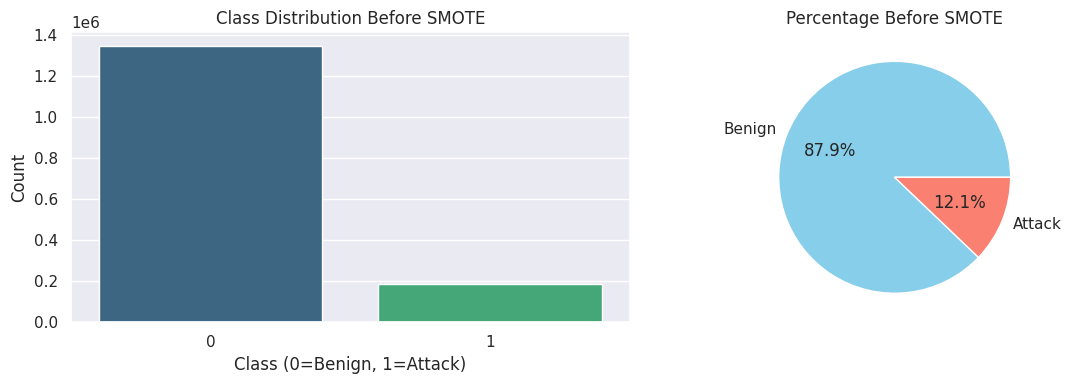

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Before SMOTE
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x=y_train, palette='viridis', ax=ax[0])
ax[0].set_title('Class Distribution Before SMOTE')
ax[0].set_xlabel('Class (0=Benign, 1=Attack)')
ax[0].set_ylabel('Count')

# Percentages
y_train.value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', labels=['Benign', 'Attack'], 
                                          colors=['skyblue', 'salmon'], ax=ax[1])
ax[1].set_title('Percentage Before SMOTE')
ax[1].set_ylabel('')  
plt.tight_layout()
plt.show()

In [41]:
smote = SMOTE(random_state=42,sampling_strategy='auto' )

X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print("After SMOTE class distribution:")
print(pd.Series(y_train_smote).value_counts(normalize=True))
gc.collect() 

After SMOTE class distribution:
target
1    0.5
0    0.5
Name: proportion, dtype: float64


610

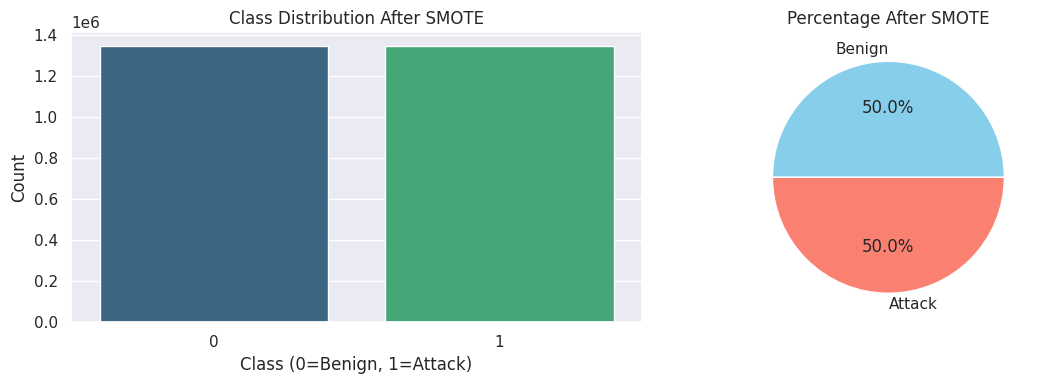

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Counts
sns.countplot(x=y_train_smote, palette='viridis', ax=ax[0])
ax[0].set_title('Class Distribution After SMOTE')
ax[0].set_xlabel('Class (0=Benign, 1=Attack)')
ax[0].set_ylabel('Count')

# Percentages
pd.Series(y_train_smote).value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', 
                                                          labels=['Benign', 'Attack'], 
                                                          colors=['skyblue', 'salmon'], ax=ax[1])
ax[1].set_title('Percentage After SMOTE')
ax[1].set_ylabel('')
plt.tight_layout()
plt.show()

In [43]:
#models
results = []

def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    start = time.time()
    model.fit(X_tr, y_tr)
    train_time = time.time() - start
    
    y_pred = model.predict(X_te)
    report = classification_report(y_te, y_pred, target_names=['Benign', 'Attack'], digits=4, output_dict=True)
    
    row = {
        'Model': name,
        'Accuracy': report['accuracy'],
        'Precision (Attack)': report['Attack']['precision'],
        'Recall (Attack)': report['Attack']['recall'],
        'F1 (Attack)': report['Attack']['f1-score'],
        'Train Time (s)': f"{train_time:.1f}"
    }
    results.append(row)
    print(f"\n{name} Report:")
    print(classification_report(y_te, y_pred, target_names=['Benign', 'Attack'], digits=4))
    return model

# decision tree
dt = DecisionTreeClassifier(max_depth=12, min_samples_split=10, random_state=42)
dt = evaluate_model("Decision Tree", dt, X_train_scaled, y_train, X_test_scaled, y_test)

# random forest
rf = RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_split=10, 
                            n_jobs=-1, class_weight='balanced', random_state=42)
rf = evaluate_model("Random Forest", rf, X_train_scaled, y_train, X_test_scaled, y_test)

# linear SVC
lsvc = LinearSVC(C=1.0, class_weight='balanced', max_iter=2000, random_state=42)
lsvc = evaluate_model("LinearSVC", lsvc, X_train_scaled, y_train, X_test_scaled, y_test)

#logistic regression
lr = LogisticRegression(C=1.0, class_weight='balanced', max_iter=1000, n_jobs=-1, random_state=42)
lr = evaluate_model("Logistic Regression", lr, X_train_scaled, y_train, X_test_scaled, y_test)

#XGBoost with smote
xgb = XGBClassifier(n_estimators=150, max_depth=8, learning_rate=0.1, 
                    random_state=42, n_jobs=-1, eval_metric='logloss')
xgb = evaluate_model("XGBoost (SMOTE)", xgb, X_train_smote, y_train_smote, X_test_scaled, y_test)

#summa
summary_df = pd.DataFrame(results).sort_values('F1 (Attack)', ascending=False)
print("\nModels Comparison:")
display(summary_df)


Decision Tree Report:
              precision    recall  f1-score   support

      Benign     0.9981    0.9993    0.9987    335914
      Attack     0.9948    0.9865    0.9906     46397

    accuracy                         0.9977    382311
   macro avg     0.9965    0.9929    0.9947    382311
weighted avg     0.9977    0.9977    0.9977    382311


Random Forest Report:
              precision    recall  f1-score   support

      Benign     0.9993    0.9965    0.9979    335914
      Attack     0.9752    0.9953    0.9851     46397

    accuracy                         0.9964    382311
   macro avg     0.9873    0.9959    0.9915    382311
weighted avg     0.9964    0.9964    0.9964    382311


LinearSVC Report:
              precision    recall  f1-score   support

      Benign     0.9959    0.9081    0.9500    335914
      Attack     0.5938    0.9730    0.7375     46397

    accuracy                         0.9159    382311
   macro avg     0.7948    0.9405    0.8437    382311
weighted 

,Model,Accuracy,Precision (Attack),Recall (Attack),F1 (Attack),Train Time (s)
0,Decision Tree,0.997735,0.994784,0.986508,0.990629,26.2
4,XGBoost (SMOTE),0.996678,0.974931,0.998297,0.986476,23.2
1,Random Forest,0.996354,0.975166,0.995301,0.985131,109.2
3,Logistic Regression,0.919775,0.604876,0.977434,0.747295,42.5
2,LinearSVC,0.915932,0.593758,0.972994,0.737478,127.2


In [44]:
ARTIFACTS_DIR = '/kaggle/working/sentinelnet_artifacts'
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

BEST_MODEL = xgb                 
BEST_NAME  = "XGBoost_SMOTE"    

joblib.dump(BEST_MODEL,   os.path.join(ARTIFACTS_DIR, f'{BEST_NAME}.pkl'))
joblib.dump(scaler,       os.path.join(ARTIFACTS_DIR, 'scaler.pkl'))
joblib.dump(selected_features, os.path.join(ARTIFACTS_DIR, 'selected_features.json'))

sample_df = pd.DataFrame(X_test_scaled[:10], columns=selected_features)
sample_df['true_label'] = y_test[:10].values
sample_df.to_csv(os.path.join(ARTIFACTS_DIR, 'sample_inputs.csv'), index=False)

print("Saved artifacts:")
!ls -lh {ARTIFACTS_DIR}

Saved artifacts:
total 836K
-rw-r--r-- 1 root root 6.5K Feb 25 16:32 sample_inputs.csv
-rw-r--r-- 1 root root 1.4K Feb 25 16:32 scaler.pkl
-rw-r--r-- 1 root root  605 Feb 25 16:32 selected_features.json
-rw-r--r-- 1 root root 818K Feb 25 16:32 XGBoost_SMOTE.pkl


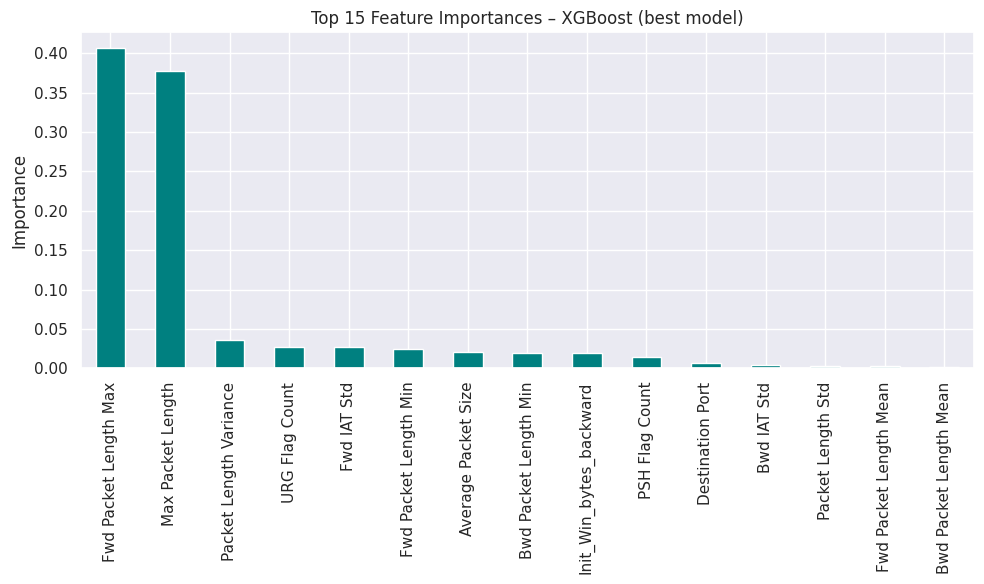

In [45]:
imp = pd.Series(xgb.feature_importances_, index=selected_features)
imp = imp.sort_values(ascending=False)[:15]

plt.figure(figsize=(10,6))
imp.plot(kind='bar', color='teal')
plt.title('Top 15 Feature Importances – XGBoost (best model)')
plt.ylabel('Importance')
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, 'feature_importance_xgboost.png'), dpi=150)
plt.show()

In [47]:
# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample
import numpy as np

print("Shape before subsampling:", X_train_smote.shape)

#subsampling
subsample_fraction = 0.4        
X_tune, y_tune = resample(
    X_train_smote, y_train_smote,
    replace=False,
    n_samples=int(len(X_train_smote) * subsample_fraction),
    random_state=42,
    stratify=y_train_smote
)

print(f"subsample shape for tuning: {X_tune.shape}")

#parameters
param_dist = {
    'n_estimators':     [100, 150, 200, 300, 400],
    'max_depth':        [4, 6, 8, 10, 12],
    'learning_rate':    [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample':        [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma':            [0, 0.1, 0.2, 0.5],          
    'reg_lambda':       [0, 0.1, 1, 5],               
    'reg_alpha':        [0, 0.1, 1]                  
}

#randomsearch
xgb_base = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    tree_method='hist'        
)

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=25,                 
    cv=3,                       
    scoring='f1',               
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)
random_search.fit(X_tune, y_tune)

print("\nbest parameters:")
print(random_search.best_params_)

print(f"\nBest CV F1-score: {random_search.best_score_:.4f}")

# top 5 combinations
cv_results = pd.DataFrame(random_search.cv_results_)
top_results = cv_results.sort_values('mean_test_score', ascending=False).head(5)
print("\nTop 5 parameter combinations:")
print(top_results[['params', 'mean_test_score', 'std_test_score', 'mean_fit_time']])

print("\ntraining final model on full data with best parameters")
best_xgb = XGBClassifier(**random_search.best_params_,
                         random_state=42,
                         n_jobs=-1,
                         eval_metric='logloss',
                         tree_method='hist')

best_xgb.fit(X_train_smote, y_train_smote)

y_pred_best = best_xgb.predict(X_test_scaled)
print("\nFinal tuned XGBoost on test set:")
print(classification_report(y_test, y_pred_best,
                            target_names=['Benign', 'Attack'],
                            digits=4))
print("\nprevious untuned XGBoost F1 (Attack): 0.9865")

Shape before subsampling: (2687312, 30)
subsample shape for tuning: (1074924, 30)
Fitting 3 folds for each of 25 candidates, totalling 75 fits

best parameters:
{'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.9}

Best CV F1-score: 0.9976

Top 5 parameter combinations:
                                               params  mean_test_score  \
10  {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha...         0.997599   
11  {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alp...         0.997591   
3   {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alp...         0.997578   
19  {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alp...         0.997577   
15  {'subsample': 0.9, 'reg_lambda': 0, 'reg_alpha...         0.997570   

    std_test_score  mean_fit_time  
10        0.000087      32.234422  
11        0.000126      23.377982  
3         0.000118      16.417874  
19        0.000122      27.953645  
15    

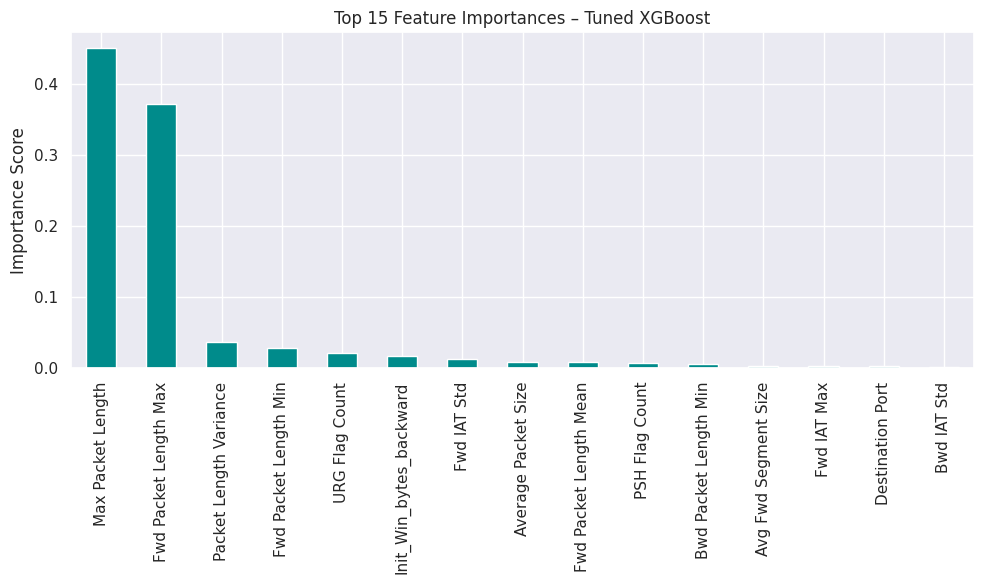

In [48]:
import matplotlib.pyplot as plt

imp = pd.Series(best_xgb.feature_importances_, index=selected_features)
imp = imp.sort_values(ascending=False)[:15]

plt.figure(figsize=(10,6))
imp.plot(kind='bar', color='darkcyan')
plt.title('Top 15 Feature Importances – Tuned XGBoost')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, 'feature_importance_tuned.png'), dpi=150, bbox_inches='tight')
plt.show()

In [49]:
import joblib
import json
import os

ARTIFACTS_DIR = '/kaggle/working/sentinelnet_artifacts'
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Save tuned model
joblib.dump(best_xgb, os.path.join(ARTIFACTS_DIR, 'best_xgboost_tuned.pkl'))
joblib.dump(scaler, os.path.join(ARTIFACTS_DIR, 'standard_scaler.pkl'))
with open(os.path.join(ARTIFACTS_DIR, 'selected_features.json'), 'w') as f:
    json.dump(selected_features, f)

sample_df = pd.DataFrame(X_test_scaled[:15], columns=selected_features)
sample_df['true_label'] = y_test[:15].values
sample_df.to_csv(os.path.join(ARTIFACTS_DIR, 'sample_inputs_15.csv'), index=False)

print("Tuned model & artifacts saved:")
!ls -lh {ARTIFACTS_DIR}

Tuned model & artifacts saved:
total 2.8M
-rw-r--r-- 1 root root 1.7M Feb 25 16:57 best_xgboost_tuned.pkl
-rw-r--r-- 1 root root  97K Feb 25 16:57 feature_importance_tuned.png
-rw-r--r-- 1 root root 106K Feb 25 16:33 feature_importance_xgboost.png
-rw-r--r-- 1 root root 9.4K Feb 25 16:57 sample_inputs_15.csv
-rw-r--r-- 1 root root 6.5K Feb 25 16:32 sample_inputs.csv
-rw-r--r-- 1 root root 1.4K Feb 25 16:32 scaler.pkl
-rw-r--r-- 1 root root  619 Feb 25 16:57 selected_features.json
-rw-r--r-- 1 root root 1.4K Feb 25 16:57 standard_scaler.pkl
-rw-r--r-- 1 root root 818K Feb 25 16:32 XGBoost_SMOTE.pkl


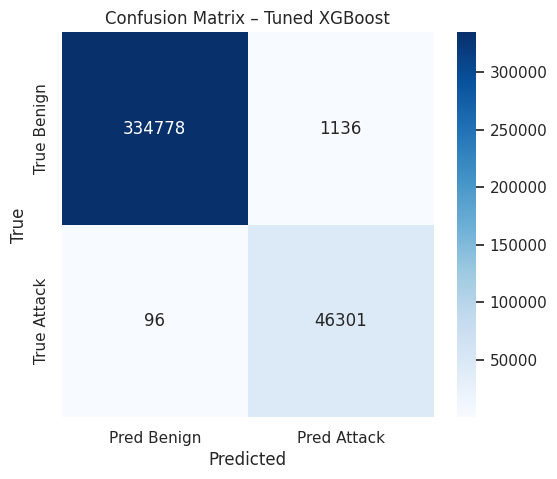

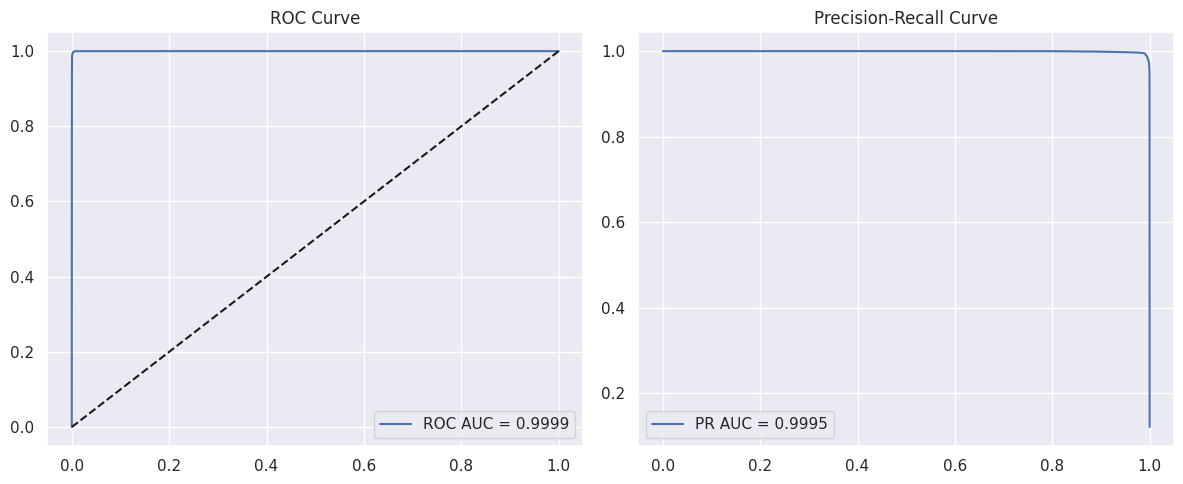

In [50]:
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
import seaborn as sns

y_pred = best_xgb.predict(X_test_scaled)
y_prob = best_xgb.predict_proba(X_test_scaled)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Benign', 'Pred Attack'],
            yticklabels=['True Benign', 'True Attack'])
plt.title('Confusion Matrix – Tuned XGBoost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(os.path.join(ARTIFACTS_DIR, 'confusion_matrix_tuned.png'), dpi=150)
plt.show()

# ROC & PR Curves
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(rec, prec)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
ax1.plot([0,1],[0,1],'k--')
ax1.set_title('ROC Curve')
ax1.legend()

ax2.plot(rec, prec, label=f'PR AUC = {pr_auc:.4f}')
ax2.set_title('Precision-Recall Curve')
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, 'roc_pr_tuned.png'), dpi=150)
plt.show()

In [52]:
#isolation forest-unsupervised learning
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import time
import numpy as np

benign_mask = (y_train == 0)
X_train_benign = X_train_scaled[benign_mask]

start = time.time()
iso_forest = IsolationForest(
    n_estimators=200,          
    contamination=0.12,      
    max_samples=0.25,       
    random_state=42,
    n_jobs=-1
)
iso_forest.fit(X_train_benign)
train_time = time.time() - start
print(f"Training time: {train_time:.1f} s (on benign only)")

# -1 = anomoly , 1 = normal
iso_pred = iso_forest.predict(X_test_scaled)
iso_pred_binary = np.where(iso_pred == -1, 1, 0)  
iso_scores = iso_forest.decision_function(X_test_scaled)
print("\nIsolation Forest:")
print(classification_report(y_test, iso_pred_binary, target_names=['Benign', 'Attack'], digits=4))

cm_iso = confusion_matrix(y_test, iso_pred_binary)
print("Confusion Matrix:\n", cm_iso)

tn, fp, fn, tp = cm_iso.ravel()
print(f"False Alarm Rate (FAR): {fp / (fp + tn):.4f}")
print(f"Miss Rate: {fn / (fn + tp):.4f}")
print(f"ROC-AUC (anomaly scores): {roc_auc_score(y_test, -iso_scores):.4f}")

joblib.dump(iso_forest, os.path.join(ARTIFACTS_DIR, 'isolation_forest.pkl'))

Training time: 50.1 s (on benign only)

Isolation Forest:
              precision    recall  f1-score   support

      Benign     0.9111    0.8801    0.8954    335914
      Attack     0.3036    0.3784    0.3369     46397

    accuracy                         0.8192    382311
   macro avg     0.6074    0.6293    0.6161    382311
weighted avg     0.8374    0.8192    0.8276    382311

Confusion Matrix:
 [[295651  40263]
 [ 28841  17556]]
False Alarm Rate (FAR): 0.1199
Miss Rate: 0.6216
ROC-AUC (anomaly scores): 0.8022


['/kaggle/working/sentinelnet_artifacts/isolation_forest.pkl']

In [53]:
# Simple ensemble: Flag as attack if EITHER model says so
y_pred_sup = best_xgb.predict(X_test_scaled)  
y_pred_unsup = iso_pred_binary

y_pred_hybrid = np.logical_or(y_pred_sup, y_pred_unsup).astype(int)

print("\nHybrid (XGBoost + Isolation Forest):")
print(classification_report(y_test, y_pred_hybrid, target_names=['Benign', 'Attack'], digits=4))


Hybrid (XGBoost + Isolation Forest):
              precision    recall  f1-score   support

      Benign     0.9997    0.8768    0.9342    335914
      Attack     0.5281    0.9980    0.6907     46397

    accuracy                         0.8915    382311
   macro avg     0.7639    0.9374    0.8124    382311
weighted avg     0.9424    0.8915    0.9047    382311



In [54]:
import logging
from datetime import datetime

# Set up simple logging (in production: use email/Slack)
logging.basicConfig(filename=os.path.join(ARTIFACTS_DIR, 'alerts.log'),
                    level=logging.INFO,
                    format='%(asctime)s - %(message)s')

def generate_alert(flow_data, prediction, prob=None, model_name='XGBoost'):
    if prediction == 1:  # Attack detected
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        alert_msg = (f"ALERT: Potential Attack Detected! "
                     f"Model: {model_name} | Probability: {prob:.4f} | "
                     f"Timestamp: {timestamp} | Flow Details: {flow_data}")
        
        # Log to file
        logging.info(alert_msg)
        
        # Print for demo (in backend: send email/SMS)
        print(alert_msg)
        
        # Optional: Simulate email (requires setup – skip for now)
        # import smtplib  # Configure SMTP for real emails

# Demo on 10 test samples
print("\nSimulating alerts on 10 test flows...")
for i in range(10):
    flow = X_test_scaled[i:i+1]  # single flow
    pred = best_xgb.predict(flow)[0]
    prob = best_xgb.predict_proba(flow)[0][1] if pred == 1 else 0.0
    generate_alert(f"Flow {i+1} (features: {flow[0][:5]}...)", pred, prob)

# View log file
print("\nAlerts logged to: alerts.log")
!cat {ARTIFACTS_DIR}/alerts.log


Simulating alerts on 10 test flows...

Alerts logged to: alerts.log
